# Perform batch correction: ComBat, BBKNN and scGEN, on a dataset merge between the developmental habenula and two adult habenula datasets.
The datasets are merged using a simple merge in Seurat. After batch effect removal, the correction is validated using technical validation methods, batch ARI and batch LISI in R, and biological methods, cell type ARI and cell type LISI in R and with the aid of PC cells.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import scanpy.external as sce
import bbknn
import mnnpy as mnn
import scgen
import matplotlib.pyplot as plt
import matplotlib as mpl

#settings
sc.settings.verbosity = 3             # show: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.figdir = "../../figures/merge_adult/"
sc.settings.set_figure_params(dpi=80)

C:\Users\Juliska\Anaconda3\envs\UMCU\lib\site-packages\anndata\_core\anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.


scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [2]:
adata = sc.read_h5ad("../../data/output/merge_adult/BatchTest_Merged_Oct20.h5ad")
adata

AnnData object with n_obs × n_vars = 12110 × 37419 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA'
    var: 'features'

In [3]:
#metadata on the cells
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA
Habenula_012___E11_1__X009,Habenula,4468.645516,2451
Habenula_012___E11_1__X011,Habenula,6744.028917,6548
Habenula_012___E11_1__X012,Habenula,6180.065762,5508
Habenula_012___E11_1__X013,Habenula,6271.142758,5609
Habenula_012___E11_1__X014,Habenula,6392.417154,6783
...,...,...,...
hab_161103_017997_R,hab,4797.000000,2329
hab_161105_023441_L,hab,709.000000,490
hab_161105_025095_R,hab,4639.000000,2407
hab_161103_014460_L,hab,571.000000,468


In [4]:
#give each cell their original cell type
text_file = open("../../data/output/merge_adult/BatchTest_identlist_Oct20.txt", "r")
all_idents = text_file.read().split('\n')
del all_idents[-1]
adata.obs["orig.celltype"] = all_idents

... storing 'orig.ident' as categorical
... storing 'orig.celltype' as categorical


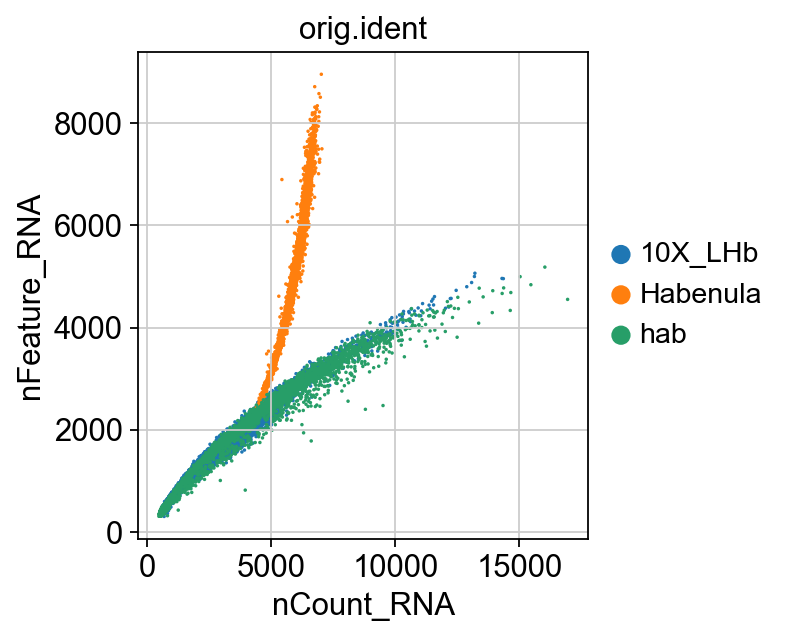

In [5]:
sc.pl.scatter(adata, x='nCount_RNA', y='nFeature_RNA', color="orig.ident")

Normalization and logtransformation

In [6]:
sc.pp.normalize_total(adata, key_added='n_counts_norm',layers = 'all')

normalizing counts per cell
    finished (0:00:00)


In [7]:
sc.pp.log1p(adata)

In [8]:
adata

AnnData object with n_obs × n_vars = 12110 × 37419 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'orig.celltype', 'n_counts_norm'
    var: 'features'
    uns: 'orig.ident_colors', 'log1p'

Determine and filter on highly variable genes (HVG)

extracting highly variable genes
    finished (0:00:09)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


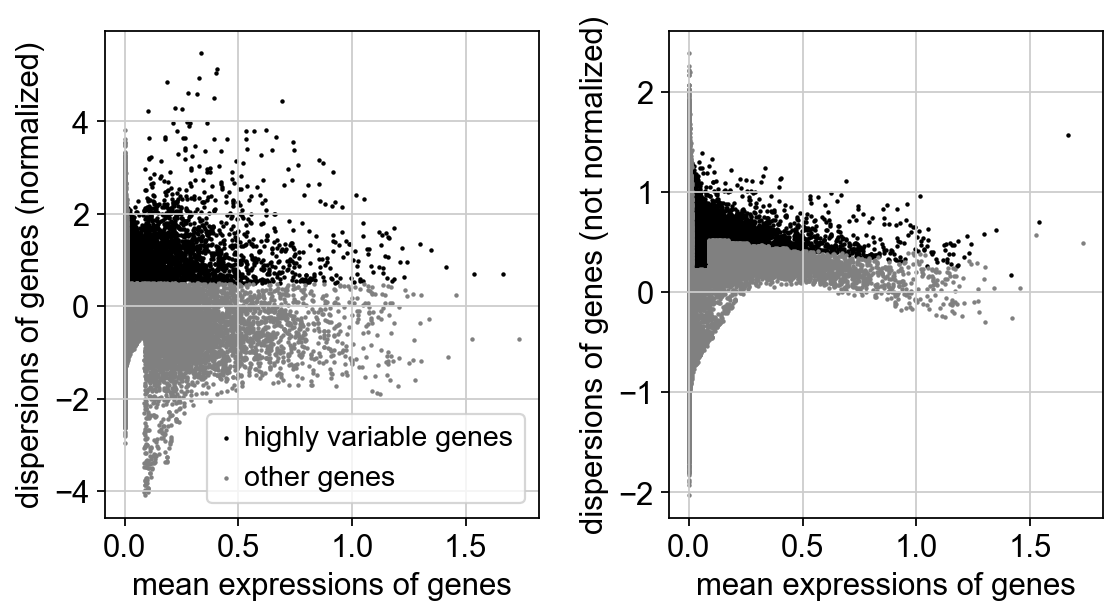

In [9]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [10]:
#filter on HVG
adata = adata[:, adata.var['highly_variable']]
adata

View of AnnData object with n_obs × n_vars = 12110 × 6233 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'orig.celltype', 'n_counts_norm'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'orig.ident_colors', 'log1p'

Regress out effects of total counts per cell expressed. Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [11]:
sc.pp.regress_out(adata, 'nCount_RNA')
sc.pp.scale(adata, max_value=10)

regressing out nCount_RNA
    sparse input is densified and may lead to high memory use
    finished (0:04:28)


## Principle component analysis
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [12]:
#pca
sc.tl.pca(adata, svd_solver='arpack')

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:20)


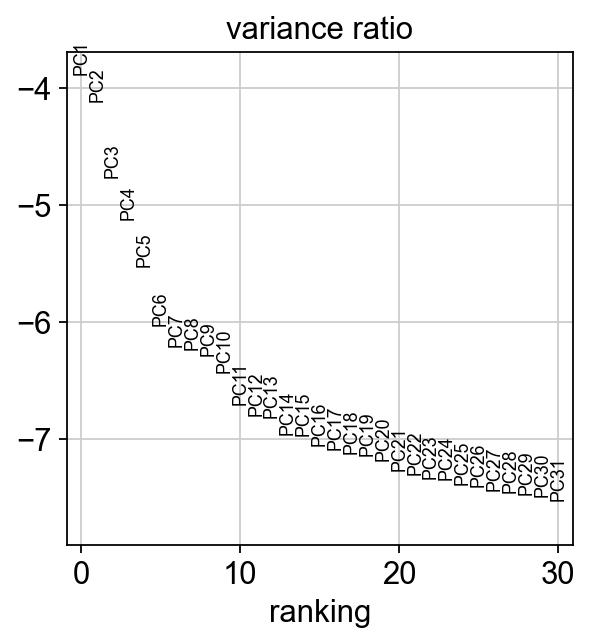

In [13]:
sc.pl.pca_variance_ratio(adata, log=True)

Copy our object to a new object for visualizing the raw (uncorrected) merge.

In [14]:
adata_cp = adata.copy()

Determine the nearest neighborhood graph, calculate tSNE coordinates (for plotting), cluster the data using louvain clustering.

In [15]:
sc.pp.neighbors(adata_cp, n_neighbors=10, n_pcs=40) 
sc.tl.tsne(adata_cp)
sc.tl.louvain(adata_cp)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:38)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:05:21)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:07)


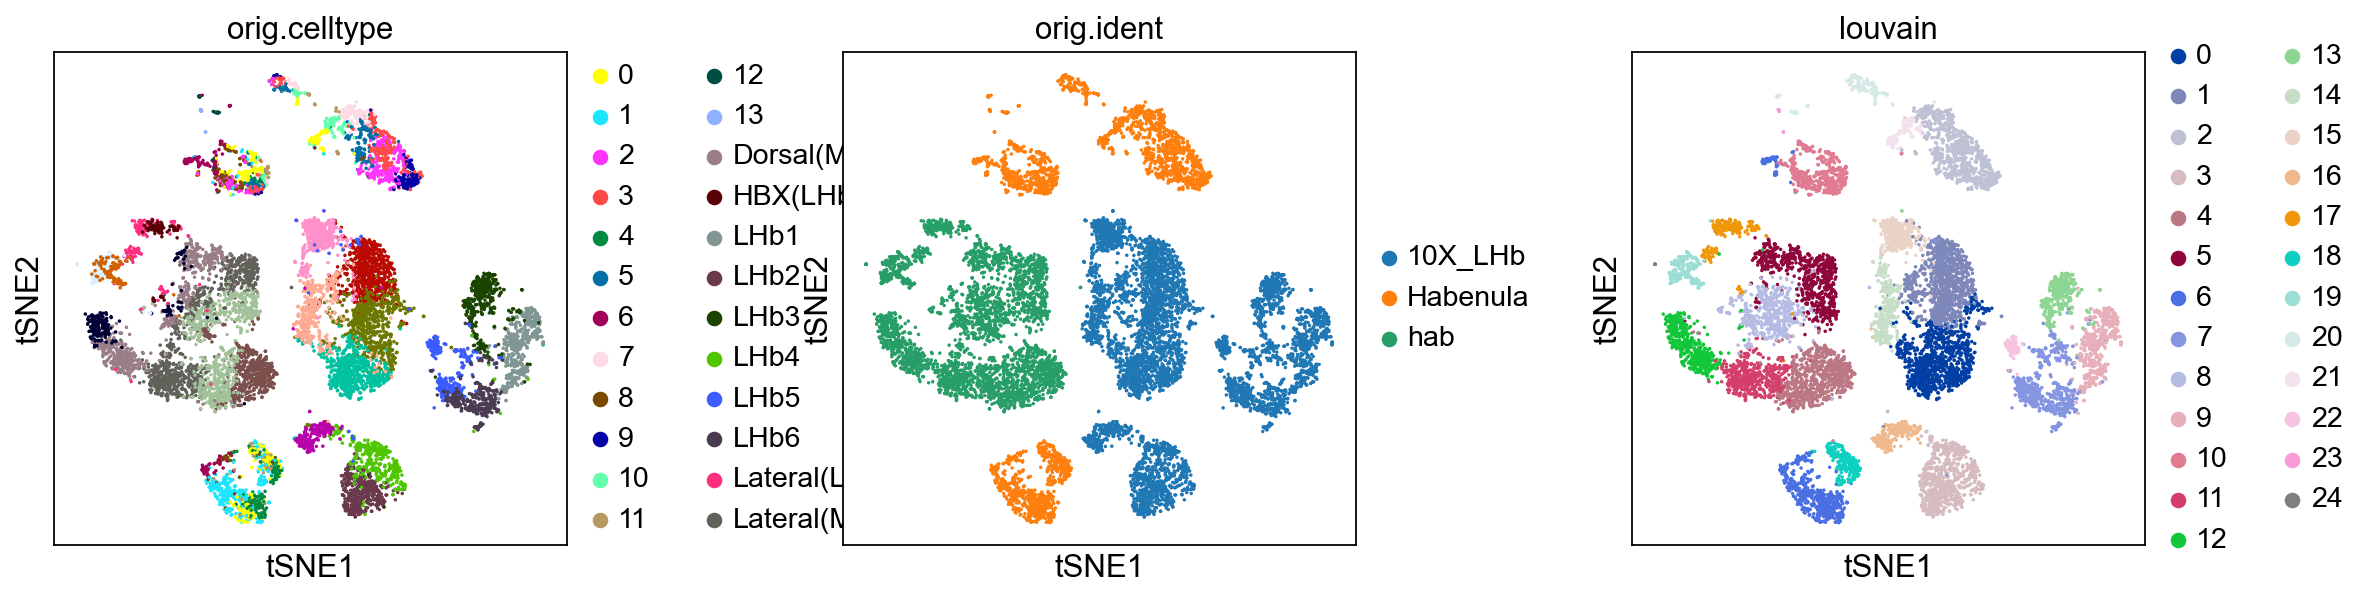

In [16]:
sc.pl.tsne(adata_cp, color=['orig.celltype', 'orig.ident', 'louvain'], wspace=0.4)

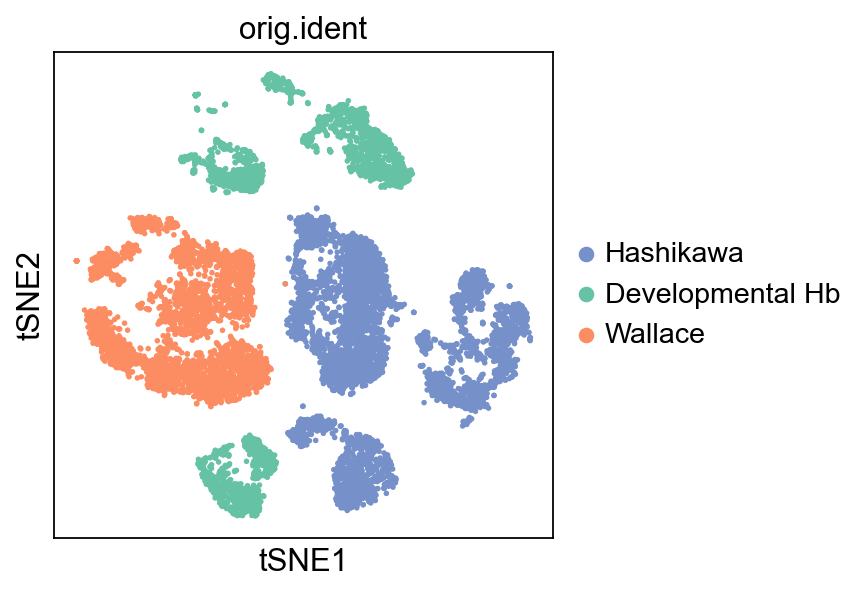

In [17]:
new_dataset_names = ['Hashikawa', 'Developmental Hb','Wallace']
adata_cp.rename_categories('orig.ident', new_dataset_names)
adata_cp.uns["orig.ident_colors"] = ["#7690ca", "#66c2a5", "#fc8d62"]
sc.pl.tsne(adata_cp, color="orig.ident", s=25, save="_scanpy_raw_batch.pdf")

Perform validation. Export metadata and tSNE coordinates to excel files for validation in R.

In [18]:
adata_cp.obs.to_csv("../../data/output/merge_adult/BatchTest_raw_metadata.csv")

In [19]:
tsne_cp = pd.DataFrame(adata_cp.obsm["X_tsne"])
tsne_cp.index = adata_cp.obs.index
tsne_cp

,0,1
Habenula_012___E11_1__X009,-16.000861,-49.676753
Habenula_012___E11_1__X011,-26.168475,55.688283
Habenula_012___E11_1__X012,-22.135672,-41.610894
Habenula_012___E11_1__X013,-13.533465,-48.189344
Habenula_012___E11_1__X014,-17.932701,-42.272102
...,...,...
hab_161103_017997_R,-45.907796,14.735696
hab_161105_023441_L,-46.072410,10.407142
hab_161105_025095_R,-45.880546,13.652650
hab_161103_014460_L,-44.971349,8.984027


In [20]:
tsne_cp.to_csv("../../data/output/merge_adult/BatchTest_raw_tsne.csv")

Determine biological correction validation: highest number of PC cells clustered together and fraction of PC cells in that cluster.

In [21]:
pc_cells = list(adata_cp.obs[(adata_cp.obs["orig.celltype"] == "12") | (adata_cp.obs["orig.celltype"] == "13")].index)

In [22]:
cluster_cp = adata_cp.obs.loc[pc_cells]["louvain"].value_counts().index[0]
 
#calculate highest percentage of PC cells clustered together
(adata_cp.obs.loc[pc_cells]["louvain"].value_counts().iloc[0] / len(pc_cells))*100

69.33333333333334

In [23]:
highest_cluster_cp = list(adata_cp.obs[adata_cp.obs["louvain"] == cluster_cp].index)

#calculate percentage of PC cells in highest ranking PC cluster
len(list(set(highest_cluster_cp) & set(pc_cells))) / len(highest_cluster_cp) * 100

21.75732217573222

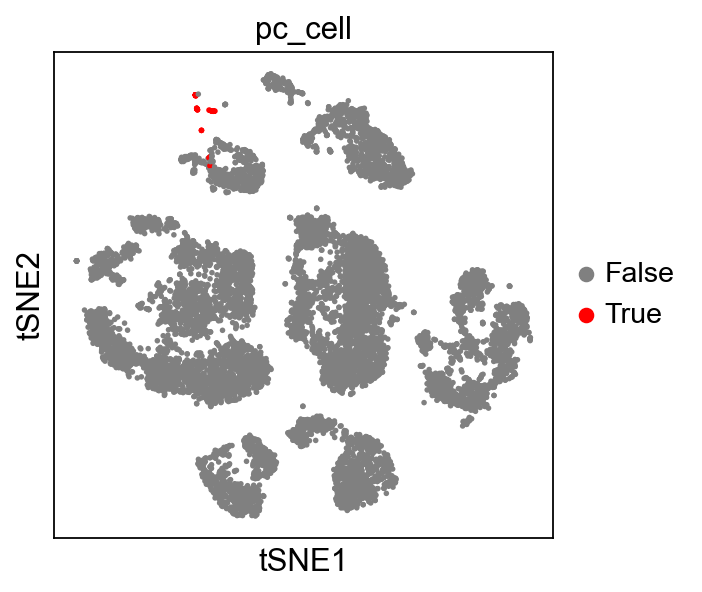

In [24]:
adata_cp.obs['pc_cell'] = pd.Categorical(adata_cp.obs.index.isin(pc_cells))
adata_cp.uns['pc_cell_colors'] = ['grey', 'red']
sc.pl.tsne(adata_cp, color='pc_cell', s=25, save="_scanpy_raw_pc.pdf")

#### Perform batch effect correction using BBKNN
Copy original object to object for BBKNN batch correction.

In [25]:
adata_b = adata.copy()

In [26]:
sc.pp.neighbors(adata_b, n_neighbors=10, n_pcs=40) 

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:13)


In [27]:
sc.external.pp.bbknn(adata_b, batch_key="orig.ident")

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:17)


BBKNN alters the nearest neighborhood graph, so we don't calculate that again.
Calculate UMAP coordinates (BBKNN does not work with tSNE) and clustering using Louvain clustering.

In [28]:
sc.tl.umap(adata_b)
sc.tl.louvain(adata_b)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:04)


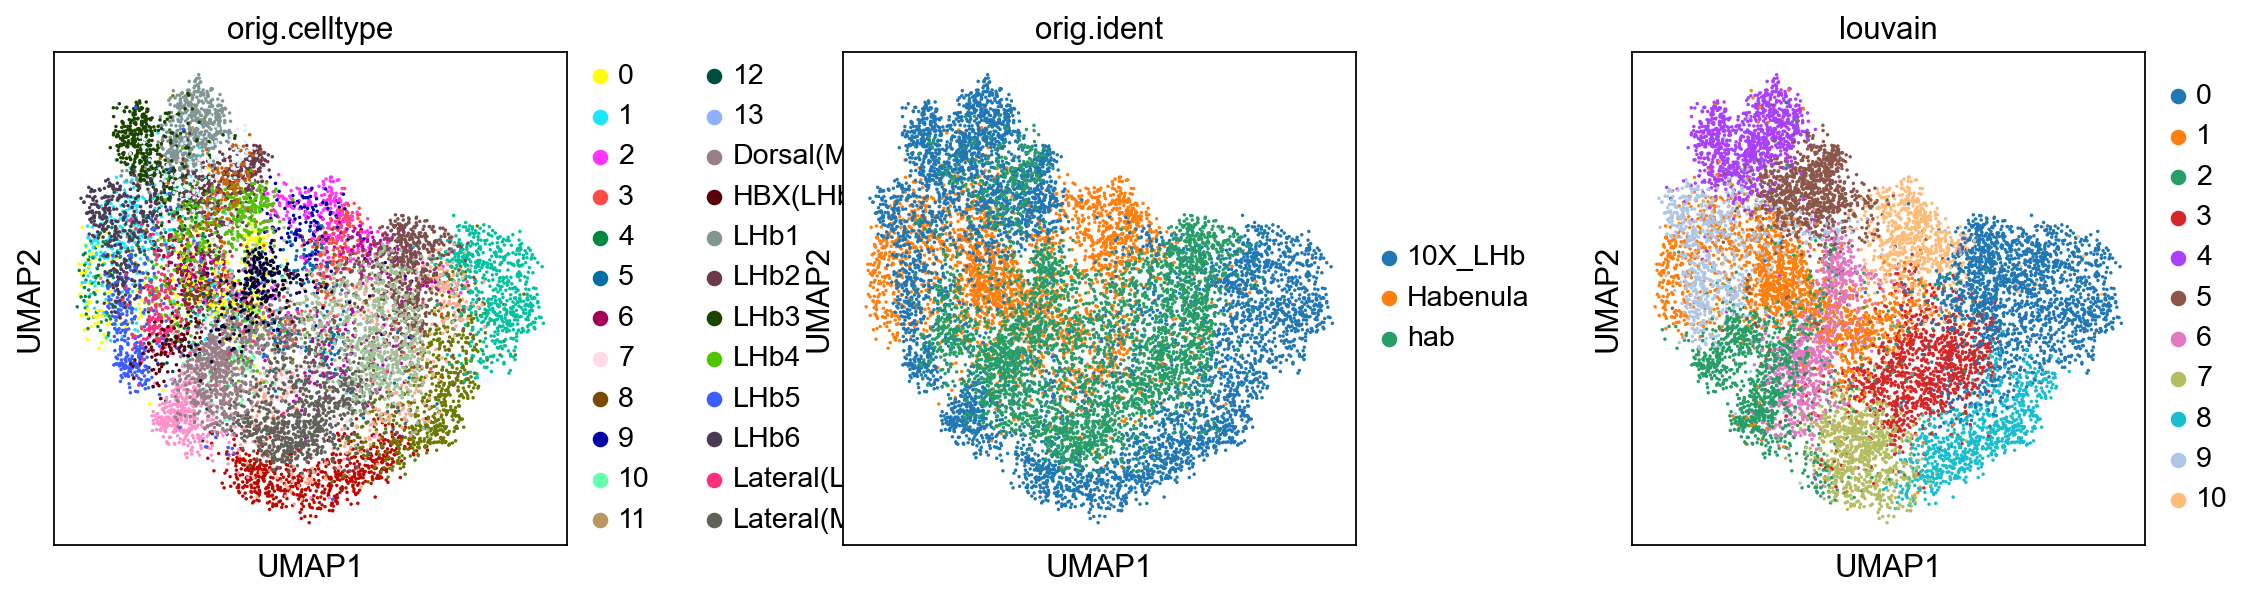

In [29]:
sc.pl.umap(adata_b, color=['orig.celltype', 'orig.ident', 'louvain'], wspace=0.4)

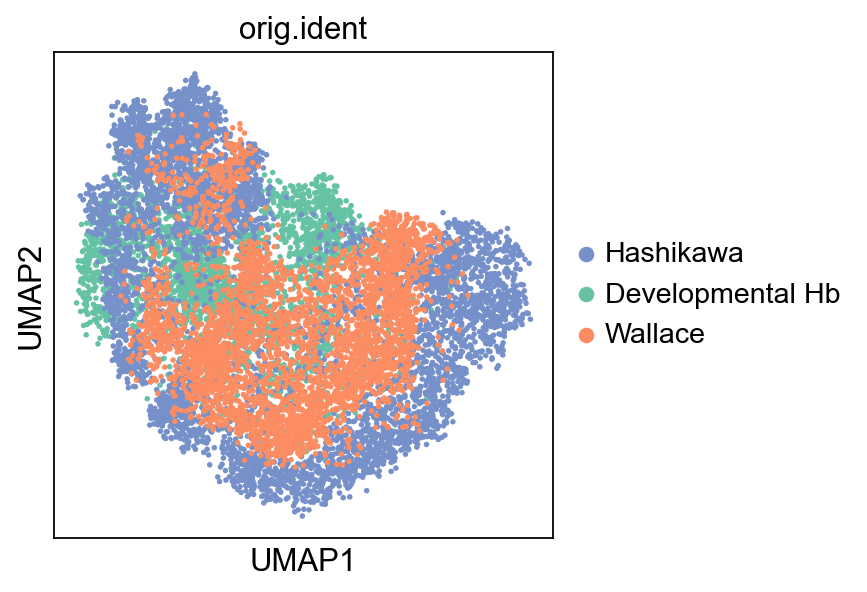

In [30]:
new_dataset_names = ['Hashikawa', 'Developmental Hb','Wallace']
adata_b.rename_categories('orig.ident', new_dataset_names)
adata_b.uns["orig.ident_colors"] = ["#7690ca", "#66c2a5", "#fc8d62"]
sc.pl.umap(adata_b, color="orig.ident", s=25, save="_bbknn_batch.pdf")

Perform validation. Export metadata and tSNE coordinates to excel files for validation in R.

In [31]:
adata_b.obs.to_csv("../../data/output/merge_adult/BatchTest_BBKNN_metadata.csv")

In [32]:
umap_b = pd.DataFrame(adata_b.obsm["X_umap"])
umap_b.index = adata_b.obs.index
umap_b

,0,1
Habenula_012___E11_1__X009,-4.402213,-0.651077
Habenula_012___E11_1__X011,-2.149880,-3.518440
Habenula_012___E11_1__X012,-4.544578,2.305364
Habenula_012___E11_1__X013,-5.686128,-0.448692
Habenula_012___E11_1__X014,-5.055004,3.230685
...,...,...
hab_161103_017997_R,-1.512655,2.840362
hab_161105_023441_L,-2.071667,2.608531
hab_161105_025095_R,-1.943450,3.507901
hab_161103_014460_L,-0.361399,2.712511


In [33]:
umap_b.to_csv("../../data/output/merge_adult/BatchTest_BBKNN_umap.csv")

Determine biological correction validation: highest number of PC cells clustered together and fraction of PC cells in that cluster.

In [34]:
pc_cells = list(adata_b.obs[(adata_b.obs["orig.celltype"] == "12") | (adata_b.obs["orig.celltype"] == "13")].index)

In [35]:
cluster_b = adata_b.obs.loc[pc_cells]["louvain"].value_counts().index[0]
 
#calculate highest percentage of PC cells clustered together
(adata_b.obs.loc[pc_cells]["louvain"].value_counts().iloc[0] / len(pc_cells))*100

80.0

In [36]:
highest_cluster_b = list(adata_b.obs[adata_b.obs["louvain"] == cluster_b].index)

#calculate percentage of PC cells in highest ranking PC cluster
len(list(set(highest_cluster_b) & set(pc_cells))) / len(highest_cluster_b) * 100

5.008347245409015

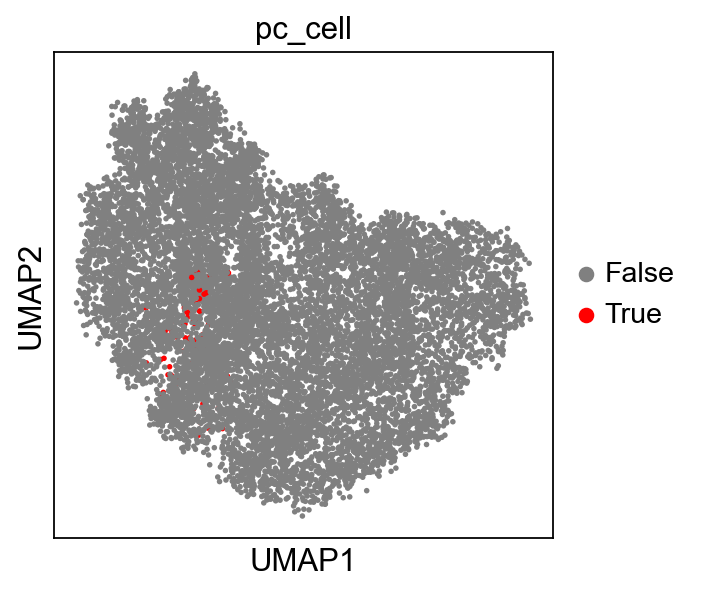

In [37]:
adata_b.obs['pc_cell'] = pd.Categorical(adata_b.obs.index.isin(pc_cells))
adata_b.uns['pc_cell_colors'] = ['grey', 'red']
sc.pl.umap(adata_b, color='pc_cell', s=25, save="_bbknn_pc.pdf")

#### Perform batch effect correction using ComBat
Copy original object to object for ComBat batch correction.

In [38]:
adata_c = adata.copy()

In [39]:
sc.pp.combat(adata_c, key='orig.ident', covariates=None, inplace=True)

Standardizing Data across genes.

Found 3 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



Calculate the PCA, determine the nearest neighborhood graph, calculate tSNE coordinates (for plotting), cluster the data using louvain clustering.

In [40]:
sc.tl.pca(adata_c, svd_solver='arpack')
sc.pp.neighbors(adata_c, n_neighbors=10, n_pcs=40) 
sc.tl.tsne(adata_c)
sc.tl.louvain(adata_c)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:36)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:08)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:53)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 24 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


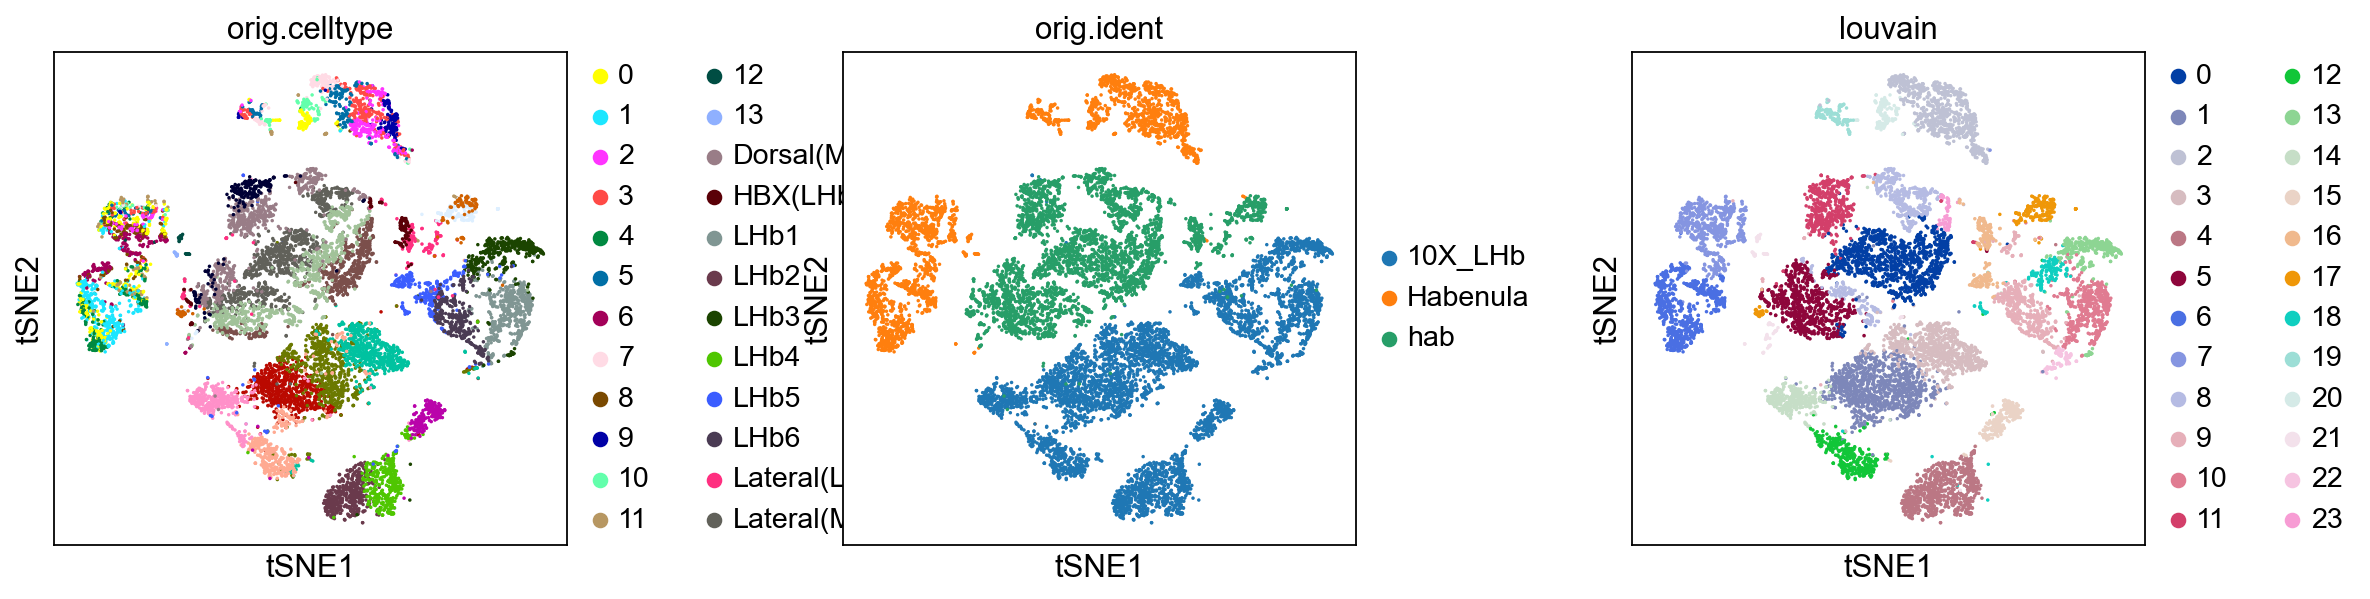

In [41]:
sc.pl.tsne(adata_c, color=['orig.celltype', 'orig.ident', 'louvain'], wspace=0.4)

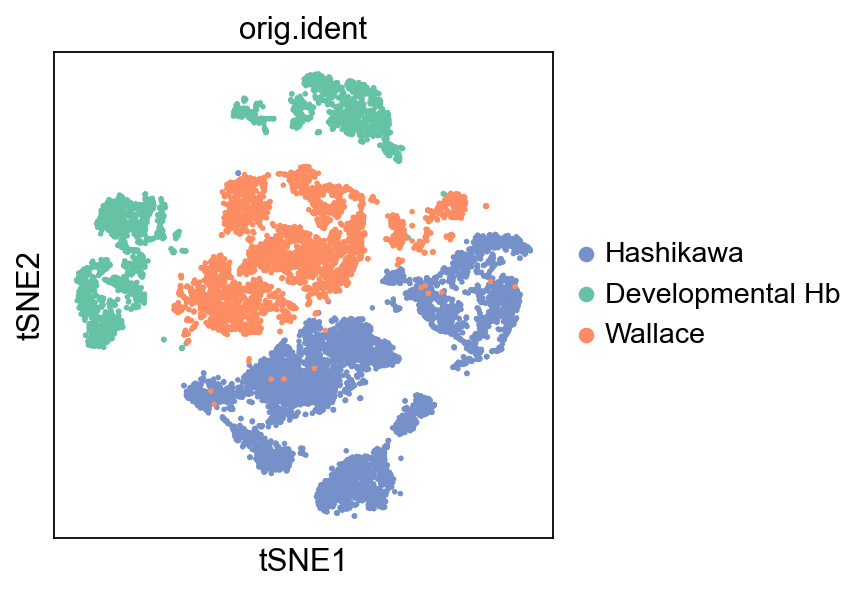

In [42]:
new_dataset_names = ['Hashikawa', 'Developmental Hb','Wallace']
adata_c.rename_categories('orig.ident', new_dataset_names)
adata_c.uns["orig.ident_colors"] = ["#7690ca", "#66c2a5", "#fc8d62"]
sc.pl.tsne(adata_c, color="orig.ident", s=25, save="_combat_batch.pdf")

Perform validation. Export metadata and tSNE coordinates to excel files for validation in R.

In [43]:
adata_c.obs.to_csv("../../data/output/merge_adult/BatchTest_ComBat_metadata.csv")

In [44]:
tsne_c = pd.DataFrame(adata_c.obsm["X_tsne"])
tsne_c.index = adata_c.obs.index
tsne_c

,0,1
Habenula_012___E11_1__X009,-59.257237,3.464107
Habenula_012___E11_1__X011,-32.078456,11.396298
Habenula_012___E11_1__X012,-49.576636,-6.865650
Habenula_012___E11_1__X013,-54.441935,-9.625712
Habenula_012___E11_1__X014,-51.582060,-7.866397
...,...,...
hab_161103_017997_R,36.530522,15.577791
hab_161105_023441_L,-33.673605,-4.662375
hab_161105_025095_R,35.570409,15.156232
hab_161103_014460_L,-32.830629,-4.227141


In [45]:
tsne_c.to_csv("../../data/output/merge_adult/BatchTest_ComBat_tsne.csv")

Determine biological correction validation: highest number of PC cells clustered together and fraction of PC cells in that cluster.

In [46]:
pc_cells = list(adata_c.obs[(adata_c.obs["orig.celltype"] == "12") | (adata_c.obs["orig.celltype"] == "13")].index)

In [47]:
cluster_c = adata_c.obs.loc[pc_cells]["louvain"].value_counts().index[0]
 
#calculate highest percentage of PC cells clustered together
(adata_c.obs.loc[pc_cells]["louvain"].value_counts().iloc[0] / len(pc_cells))*100

94.66666666666667

In [48]:
highest_cluster_c = list(adata_c.obs[adata_c.obs["louvain"] == cluster_c].index)

#calculate percentage of PC cells in highest ranking PC cluster
len(list(set(highest_cluster_c) & set(pc_cells))) / len(highest_cluster_c) * 100

52.98507462686567

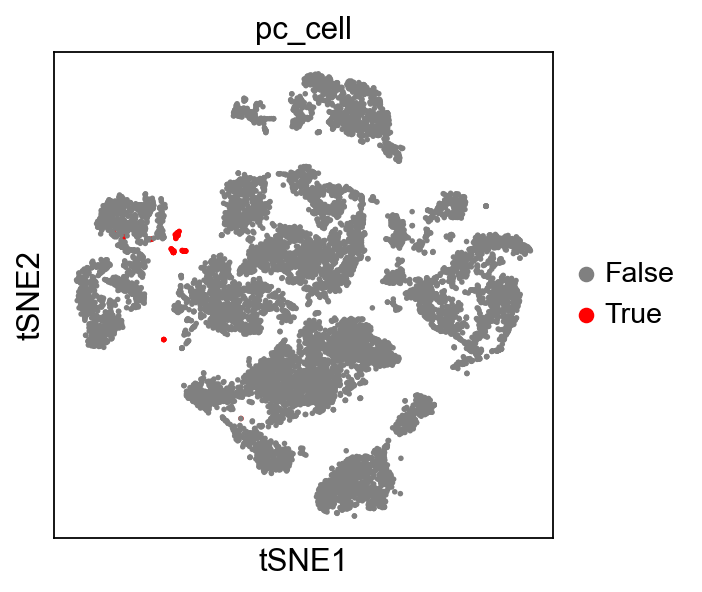

In [49]:
adata_c.obs['pc_cell'] = pd.Categorical(adata_c.obs.index.isin(pc_cells))
adata_c.uns['pc_cell_colors'] = ['grey', 'red']
sc.pl.tsne(adata_c, color='pc_cell', s=25, save="_combat_pc.pdf")

#### Perform batch effect correction using scGEN
Copy original object to new object for scGEN batch correction.

In [50]:
adata_sc = adata.copy()

In [51]:
network = scgen.VAEArith(x_dimension= adata_sc.shape[1], model_path="../../data/output/merge_adult/models/batch")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [52]:
network.train(train_data=adata_sc, n_epochs=20)

In [53]:
#throws error, dataset is too large for batch effect removal using a network
corrected_adata = scgen.batch_removal(network, adata_sc, batch_key="orig.ident", cell_label_key="orig.celltype")    

TypeError: concatenate() missing 1 required positional argument: 'self'

In [ ]:
sc.pp.neighbors(corrected_adata, n_neighbors=10, n_pcs=40) 
sc.tl.tsne(corrected_adata)
sc.tl.louvain(corrected_adata)

In [ ]:
sc.pl.tsne(corrected_adata, color=['orig.celltype', 'orig.ident', 'louvain'], wspace=0.4)

In [ ]:
corrected_adata.obs.to_csv("../../data/output/merge_adult/BatchTest_scGen_metadata.csv")

In [ ]:
tsne_sc = pd.DataFrame(corrected_adata.obsm["X_tsne"])
tsne_sc.index = corrected_adata.obs.index
tsne_sc

In [ ]:
tsne_sc.to_csv("../../data/output/merge_adult/BatchTest_scGen_tsne.csv")

In [ ]:
pc_cells = list(corrected_adata.obs[(corrected_adata.obs["orig.celltype"] == "12") | (corrected_adata.obs["orig.celltype"] == "13")].index)

In [ ]:
cluster_sc = corrected_adata.obs.loc[pc_cells]["louvain"].value_counts().index[0]
 
calculate highest percentage of PC cells clustered together
(corrected_adata.obs.loc[pc_cells]["louvain"].value_counts().iloc[0] / len(pc_cells))*100

In [ ]:
highest_cluster_sc = list(corrected_adata.obs[corrected_adata.obs["louvain"] == cluster_sc].index)

calculate percentage of PC cells in highest ranking PC cluster
len(list(set(highest_cluster_sc) & set(pc_cells))) / len(highest_cluster_sc) * 100